# 0. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE

# 1. Load Data

In [ ]:

TRAIN_FILE_PATH = '/content/drive/My Drive/IND_ability_train.csv'
TEST_FILE_PATH = '/content/drive/MyDrive/IND_ability_test.csv'

In [ ]:
df_train = pd.read_csv(TRAIN_FILE_PATH, usecols=['smiles', 'label'])
smiles_train = df_train['smiles'].tolist()
labels_train = df_train['label'].tolist()
df_test = pd.read_csv(TEST_FILE_PATH, usecols=['smiles', 'label'])
smiles_test = df_test['smiles'].tolist()
labels_test = df_test['label'].tolist()

print(f"Loaded {len(smiles_train)} training SMILES, {len(smiles_test)} test SMILES.")

Loaded 24597 training SMILES, 2732 test SMILES.


# 2. Tokenization

In [ ]:
def tokenize_smiles(smiles_str):
    """
    Convert a SMILES string to a list of single-character tokens.
    e.g., 'CC(=O)' -> ['C','C','(','=','O',')']
    """
    return list(smiles_str.strip())


#################################### PK EDITS ######################################
def atomwise_tokenizer(smiles, exclusive_tokens=None):
  """
  Tokenize a SMILES molecule at atom-level:
      (1) 'Br' and 'Cl' are two-character tokens
      (2) Symbols with bracket are considered as tokens

  exclusive_tokens: A list of specifical symbols with bracket you want to keep. e.g., ['[C@@H]', '[nH]'].
  Other symbols with bracket will be replaced by '[UNK]'. default is `None`.
  """

  pattern = "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"

  regex = re.compile(pattern)
  tokens = [token for token in regex.findall(smiles)]

  if exclusive_tokens:
      for i, tok in enumerate(tokens):
          if tok.startswith('['):
              if tok not in exclusive_tokens:
                  tokens[i] = '[UNK]'

  return tokens

In [ ]:
# # Tokenize train/test sets
# tokenized_train = [tokenize_smiles(s) for s in smiles_train]
# tokenized_test = [tokenize_smiles(s) for s in smiles_test]



#PK EDITS UNCOMMENT Below Atom based tokenization
tokenized_train = [atomwise_tokenizer(s, None) for s in smiles_train]
tokenized_test = [atomwise_tokenizer(s, None) for s in smiles_train]

# 3. Build Vocabulary

In [ ]:
def build_vocab(tokenized_data):
    """
    Takes a list of token lists and builds:
      - token_to_idx: dict mapping token -> int
      - idx_to_token: dict mapping int -> token
    """
    token_freq = defaultdict(int)
    # print(token_freq)

    # Count frequencies across all SMILES
    for tokens in tokenized_data:
        for t in tokens:
            token_freq[t] += 1
    # print(token_freq)

    # Sort tokens by descending frequency
    sorted_tokens = sorted(token_freq.keys(), key=lambda x: -token_freq[x])

    token_to_idx = {}
    idx_to_token = {}

    for i, token in enumerate(sorted_tokens):
        token_to_idx[token] = i
        idx_to_token[i] = token

    return token_to_idx, idx_to_token

In [ ]:

# Build vocab from the TRAIN set only
token_to_idx, idx_to_token = build_vocab(tokenized_train)
vocab_size = len(token_to_idx)

print(f"Vocab size = {vocab_size}")

Vocab size = 65


# 4. Create CBOW Pairs

In [ ]:
def generate_cbow_samples(tokenized_data, token_to_idx, window_size=2):
    """
    Returns a list of (context_indices, target_index) pairs for CBOW.

    context_indices: list of integer token IDs around the target
    target_index   : integer token ID for the center token
    """
    cbow_samples = []
    for tokens in tokenized_data:
        indices = [token_to_idx[t] for t in tokens if t in token_to_idx]
        for i, target_idx in enumerate(indices):
            start = max(0, i - window_size)
            end   = min(len(indices), i + window_size + 1)

            # Gather neighbors (excluding the center token)
            context_list = []
            for j in range(start, end):
                if j != i:
                    context_list.append(indices[j])

            if len(context_list) == 0:
                continue

            # Add one sample: (list_of_context_tokens, target_token)
            cbow_samples.append((context_list, target_idx))

    return cbow_samples

In [ ]:
cbow_samples_train = generate_cbow_samples(tokenized_train, token_to_idx, window_size=2)
print(f"Number of CBOW samples in training set: {len(cbow_samples_train)}")

Number of CBOW samples in training set: 1071396


In [ ]:
def prepare_cbow_data(cbow_samples, max_context_size=4):
    """
    Convert (context_list, target) pairs to a NumPy array of shape:
      (num_samples, max_context_size + 1)
    We'll store:
      columns [0..max_context_size-1] => context tokens
      column  max_context_size        => target token
    We pad context lists that are shorter than max_context_size with 0.
    """
    data_rows = []
    for (ctx_list, tgt) in cbow_samples:
        # If context_list is bigger than max_context_size, truncate
        ctx = ctx_list[:max_context_size]
        # Pad if needed
        if len(ctx) < max_context_size:
            ctx += [0]*(max_context_size - len(ctx))
        # final row => [ctx_1, ctx_2, ..., ctx_N, target]
        data_rows.append(ctx + [tgt])
    return np.array(data_rows, dtype=np.int64)

In [ ]:
max_context_size = 2*2  # since window_size=2 => 4 tokens
cbow_arr_train = prepare_cbow_data(cbow_samples_train, max_context_size=max_context_size)
print(f"cbow_arr_train shape = {cbow_arr_train.shape}")

cbow_arr_train shape = (1071396, 5)


# 5. Define CBOW Model (with Negative Sampling)

In [ ]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        """
        'input_embedding': for context tokens
        'output_embedding': for target (center) tokens
        """
        super(CBOWNegativeSampling, self).__init__()
        self.embedding_dim = embedding_dim

        self.input_embedding = nn.Embedding(vocab_size, embedding_dim)   # for contexts
        self.output_embedding = nn.Embedding(vocab_size, embedding_dim)  # for targets

        # Initialize weights
        nn.init.xavier_uniform_(self.input_embedding.weight)
        nn.init.xavier_uniform_(self.output_embedding.weight)

    def forward(self, context_batch, target_batch, negative_batch):
        """
        context_batch: (batch_size, max_context_size)
        target_batch : (batch_size,)
        negative_batch: (batch_size, K)

        Returns:
          pos_score: (batch_size)   => dot(sum(context_emb), target_emb)
          neg_score: (batch_size,K) => dot(sum(context_emb), negative_emb_k)
        """
        # 1) Embed all context tokens => (batch_size, max_context_size, embedding_dim)
        context_emb = self.input_embedding(context_batch)

        # 2) Sum across context positions => (batch_size, embedding_dim)
        context_sum = torch.sum(context_emb, dim=1)

        # 3) Retrieve target embeddings => (batch_size, embedding_dim)
        target_emb = self.output_embedding(target_batch)

        # Positive score => dot(context_sum, target_emb)
        pos_score = torch.sum(context_sum * target_emb, dim=1)

        # Negative samples => shape => (batch_size, K, embedding_dim)
        neg_emb = self.output_embedding(negative_batch)

        # Expand context_sum => (batch_size, 1, embedding_dim)
        context_sum = context_sum.unsqueeze(1)

        # Dot product => (batch_size, K)
        neg_score = torch.sum(context_sum * neg_emb, dim=2)

        return pos_score, neg_score

In [ ]:
def negative_sampling_loss(pos_score, neg_score):
    """
    Negative sampling loss:
      - Maximize log(sigmoid(pos_score))
      - Maximize log(sigmoid(-neg_score)) for negative samples
    """
    # pos_score: (batch_size)
    # neg_score: (batch_size, K)

    # Avoid log(0)
    eps = 1e-9

    # Positive part: log(sigmoid(pos_score))
    pos_loss = -torch.log(torch.sigmoid(pos_score) + eps)

    # Negative part: sum of log(sigmoid(-neg_score)) over K negative samples
    neg_loss = -torch.sum(torch.log(torch.sigmoid(-neg_score) + eps), dim=1)

    return torch.mean(pos_loss + neg_loss)

# 6. Training The Model

In [ ]:
# Hyperparameters
embedding_dim   = 50
epochs          = 5
batch_size      = 64
neg_sample_size = 5
learning_rate   = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class CBOWDataset(Dataset):
    """
    Each row: [ctx_1, ctx_2, ..., ctx_n, target]
    """
    def __init__(self, data_arr):
        self.data = data_arr  # shape => (num_samples, max_context_size+1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        context = row[:-1]  # first max_context_size columns
        target  = row[-1]   # last column
        return context, target

In [ ]:
cbow_train_dataset = CBOWDataset(cbow_arr_train)
cbow_train_loader = DataLoader(cbow_train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Instantiate the model
cbow_model = CBOWNegativeSampling(vocab_size, embedding_dim).to(device)
optimizer  = optim.Adam(cbow_model.parameters(), lr=learning_rate)

# Training loop
cbow_data_size = len(cbow_arr_train)
num_batches    = cbow_data_size // batch_size
losses  = []
print("Starting CBOW training...")
for epoch in range(epochs):
    total_loss = 0.0
    loader_tqdm = tqdm(cbow_train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for context_batch, target_batch in loader_tqdm:
        context_batch = context_batch.to(device)  # shape => (batch_size, max_context_size)
        target_batch  = target_batch.to(device)   # shape => (batch_size,)

        # Negative samples => (batch_size, K)
        batch_sz = context_batch.size(0)
        neg_samples = []
        for _ in range(batch_sz):
            negs = np.random.choice(vocab_size, neg_sample_size, replace=False)
            neg_samples.append(negs)
        neg_samples = torch.LongTensor(neg_samples).to(device)

        # Forward
        pos_score, neg_score = cbow_model(context_batch, target_batch, neg_samples)

        loss = negative_sampling_loss(pos_score, neg_score)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loader_tqdm.set_postfix(loss=loss.item())

    avg_loss = total_loss / (num_batches if num_batches>0 else 1)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")

Starting CBOW training...


Epoch 1/5 - Avg Loss: 1.0217


Epoch 2/5 - Avg Loss: 1.0111


Epoch 3/5 - Avg Loss: 1.0108


Epoch 4/5 - Avg Loss: 1.0114


Epoch 5/5 - Avg Loss: 1.0110


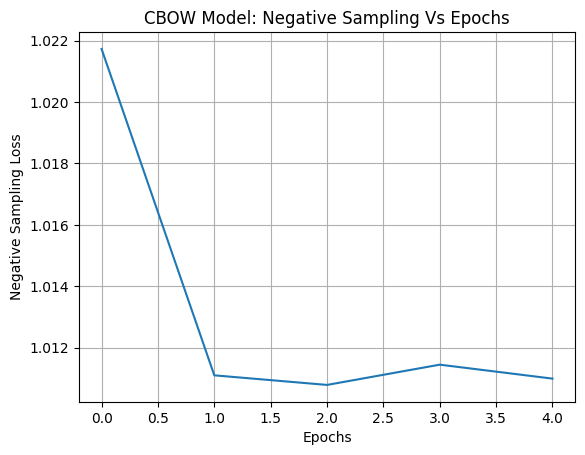

In [ ]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Negative Sampling Loss")
plt.title("CBOW Model: Negative Sampling Vs Epochs")
plt.grid()

# 7. Extract Word2Vec Embeddings

In [ ]:
def smiles_to_embedding(smiles_str, model, token_to_idx):
    """
    Convert a SMILES string to a single embedding vector by
    averaging the 'input_embedding' (or 'output_embedding') for each token.
    """
    tokens = tokenize_smiles(smiles_str)
    vecs   = []
    for t in tokens:
        if t in token_to_idx:
            idx = token_to_idx[t]
            emb = model.input_embedding.weight[idx].detach().cpu().numpy()
            vecs.append(emb)

    if len(vecs) == 0:
        return np.zeros(model.embedding_dim)
    else:
        return np.mean(vecs, axis=0)

In [ ]:
train_embeddings = []
for s in smiles_train:
    vec = smiles_to_embedding(s, cbow_model, token_to_idx)
    train_embeddings.append(vec)

test_embeddings = []
for s in smiles_test:
    vec = smiles_to_embedding(s, cbow_model, token_to_idx)
    test_embeddings.append(vec)

print(f"Train set embeddings shape: {len(train_embeddings)} x {len(train_embeddings[0]) if train_embeddings else 'unknown'}")
print(f"Test set embeddings shape:  {len(test_embeddings)} x {len(test_embeddings[0]) if test_embeddings else 'unknown'}")

Train set embeddings shape: 24597 x 50
Test set embeddings shape:  2732 x 50


In [ ]:
train_embeddings = np.array(train_embeddings)  # shape => (num_train, embedding_dim)
test_embeddings  = np.array(test_embeddings)   # shape => (num_test, embedding_dim)
labels_train_np  = np.array(labels_train)
labels_test_np   = np.array(labels_test)

# Split test into validation and final test sets (50% val, 50% test)
val_embeddings, final_test_embeddings, val_labels, final_test_labels = train_test_split(
    test_embeddings, labels_test_np, test_size=0.5, random_state=42, stratify=labels_test_np
)

In [ ]:
# Apply SMOTE to training set
smote = SMOTE(random_state=42)
train_embeddings_resampled, labels_train_resampled = smote.fit_resample(train_embeddings, labels_train_np)

print(f"Original class distribution: {np.bincount(labels_train_np)}")
print(f"Resampled class distribution: {np.bincount(labels_train_resampled)}")

Original class distribution: [16155  8442]
Resampled class distribution: [16155 16155]


# 8. Define a DATASET/LOADER For The MLP

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x = self.embeddings[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
train_dataset = EmbeddingDataset(train_embeddings, labels_train_np)
resampled_dataset = EmbeddingDataset(train_embeddings_resampled, labels_train_resampled)
# test_dataset  = EmbeddingDataset(test_embeddings,  labels_test_np)
val_dataset = EmbeddingDataset(val_embeddings, val_labels)
final_test_dataset = EmbeddingDataset(final_test_embeddings, final_test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
resampled_loader = DataLoader(resampled_dataset, batch_size=32, shuffle=True)
# test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
final_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

# 9. Define The MLP Classifier & Train


In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 8), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x).view(-1)  # shape: (batch,)

In [ ]:
from sklearn.metrics import classification_report

def train_and_evaluate_model(train_loader, val_loader, test_loader, input_dim, epochs= 20, lr=0.001, plot_loss=True):
    model = MLPClassifier(input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)
            loss = criterion(preds, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(batch_x)
        train_losses.append(total_loss / len(train_loader.dataset))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                val_loss += loss.item() * len(batch_x)
        val_losses.append(val_loss / len(val_loader.dataset))

        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    # Plot loss
    if plot_loss:
        plt.figure(figsize=(7, 4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    # Evaluate on test set
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            probs = model(batch_x).cpu()
            preds = (probs >= 0.5).float()

            all_probs.extend(probs.numpy())
            all_preds.extend(preds.numpy())
            all_targets.extend(batch_y.numpy())

    # Metrics
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds)
    rec = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    roc = roc_auc_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, all_preds)

    print("\nFinal Evaluation:")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC AUC      : {roc:.4f}")
    # Confusion Matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

    print(classification_report(all_targets , all_preds))
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
    }

Training on original imbalanced data:


Epoch 1 | Train Loss: 0.6225 | Val Loss: 0.6044


Epoch 2 | Train Loss: 0.6082 | Val Loss: 0.5974


Epoch 3 | Train Loss: 0.5987 | Val Loss: 0.5834


Epoch 4 | Train Loss: 0.5913 | Val Loss: 0.5838


Epoch 5 | Train Loss: 0.5854 | Val Loss: 0.5831


Epoch 6 | Train Loss: 0.5813 | Val Loss: 0.5807


Epoch 7 | Train Loss: 0.5752 | Val Loss: 0.5763


Epoch 8 | Train Loss: 0.5710 | Val Loss: 0.5697


Epoch 9 | Train Loss: 0.5686 | Val Loss: 0.5731


Epoch 10 | Train Loss: 0.5645 | Val Loss: 0.5703


Epoch 11 | Train Loss: 0.5617 | Val Loss: 0.5666


Epoch 12 | Train Loss: 0.5578 | Val Loss: 0.6500


Epoch 13 | Train Loss: 0.5571 | Val Loss: 0.5892


Epoch 14 | Train Loss: 0.5497 | Val Loss: 0.6314


Epoch 15 | Train Loss: 0.5484 | Val Loss: 0.6301


Epoch 16 | Train Loss: 0.5439 | Val Loss: 0.6270


Epoch 17 | Train Loss: 0.5431 | Val Loss: 0.6484


Epoch 18 | Train Loss: 0.5412 | Val Loss: 0.6268


Epoch 19 | Train Loss: 0.5363 | Val Loss: 0.6287


Epoch 20 | Train Loss: 0.5352 | Val Loss: 0.6257


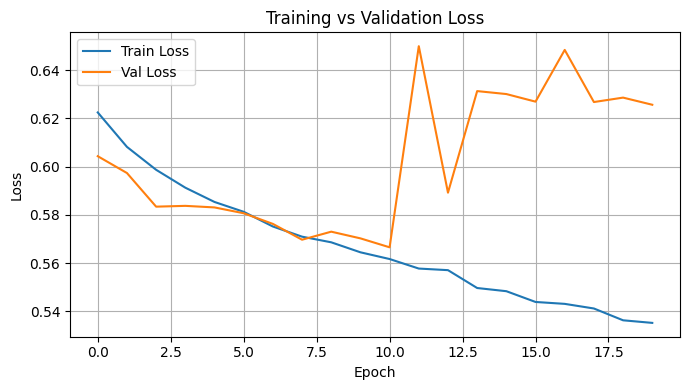


Final Evaluation:
Accuracy     : 0.7255
Precision    : 0.7771
Recall       : 0.2881
F1 Score     : 0.4204
ROC AUC      : 0.7599


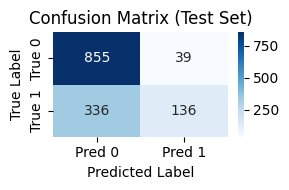

              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82       894
         1.0       0.78      0.29      0.42       472

    accuracy                           0.73      1366
   macro avg       0.75      0.62      0.62      1366
weighted avg       0.74      0.73      0.68      1366


 Training on SMOTE-resampled data:


Epoch 1 | Train Loss: 0.6634 | Val Loss: 0.6634


Epoch 2 | Train Loss: 0.6415 | Val Loss: 0.6235


Epoch 3 | Train Loss: 0.6270 | Val Loss: 0.6111


Epoch 4 | Train Loss: 0.6181 | Val Loss: 0.5919


Epoch 5 | Train Loss: 0.6099 | Val Loss: 0.6002


Epoch 6 | Train Loss: 0.6021 | Val Loss: 0.6044


Epoch 7 | Train Loss: 0.5981 | Val Loss: 0.5978


Epoch 8 | Train Loss: 0.5882 | Val Loss: 0.5788


Epoch 9 | Train Loss: 0.5819 | Val Loss: 0.6455


Epoch 10 | Train Loss: 0.5755 | Val Loss: 0.5879


Epoch 11 | Train Loss: 0.5704 | Val Loss: 0.5970


Epoch 12 | Train Loss: 0.5630 | Val Loss: 0.6787


Epoch 13 | Train Loss: 0.5604 | Val Loss: 0.5934


Epoch 14 | Train Loss: 0.5554 | Val Loss: 0.5986


Epoch 15 | Train Loss: 0.5480 | Val Loss: 0.6473


Epoch 16 | Train Loss: 0.5437 | Val Loss: 0.6603


Epoch 17 | Train Loss: 0.5353 | Val Loss: 0.6620


Epoch 18 | Train Loss: 0.5321 | Val Loss: 0.6386


Epoch 19 | Train Loss: 0.5281 | Val Loss: 0.6267


Epoch 20 | Train Loss: 0.5233 | Val Loss: 0.6354


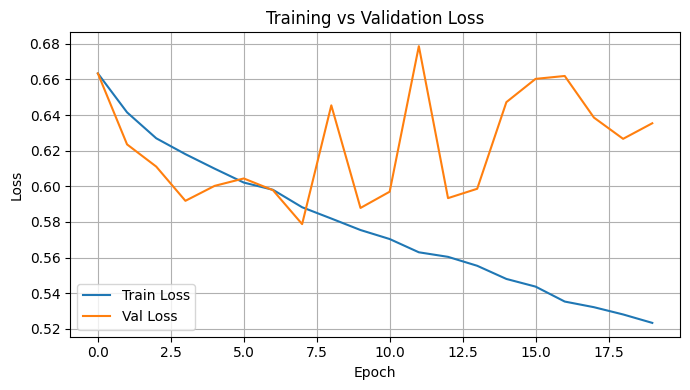


Final Evaluation:
Accuracy     : 0.6991
Precision    : 0.5480
Recall       : 0.7373
F1 Score     : 0.6287
ROC AUC      : 0.7858


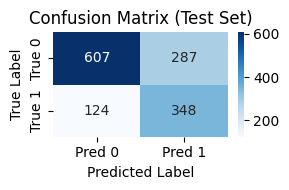

              precision    recall  f1-score   support

         0.0       0.83      0.68      0.75       894
         1.0       0.55      0.74      0.63       472

    accuracy                           0.70      1366
   macro avg       0.69      0.71      0.69      1366
weighted avg       0.73      0.70      0.71      1366



In [ ]:
print("Training on original imbalanced data:")
metrics_baseline = train_and_evaluate_model(train_loader, val_loader, final_test_loader, embedding_dim)
print("==============================================================================")
print("\n Training on SMOTE-resampled data:")
metrics_smote = train_and_evaluate_model(resampled_loader, val_loader, final_test_loader, embedding_dim)

In [ ]:
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
    "Baseline": [metrics_baseline["accuracy"], metrics_baseline["precision"],
                 metrics_baseline["recall"], metrics_baseline["f1"], metrics_baseline["roc_auc"]],
    "SMOTE": [metrics_smote["accuracy"], metrics_smote["precision"],
              metrics_smote["recall"], metrics_smote["f1"], metrics_smote["roc_auc"]]
})

print(metrics_df)

      Metric  Baseline     SMOTE
0   Accuracy  0.723280  0.734261
1  Precision  0.699153  0.604207
2     Recall  0.349576  0.669492
3   F1 Score  0.466102  0.635176
4    ROC AUC  0.765562  0.787194
